# ISB-CGC Community Notebooks



```
Title:   How to make a heatmap using BigQuery 
Author:  David L Gibbs
Created: 2019-12-02
Purpose: Demonstrate how to make a correlation matrix and create a heatmap visualization.
Notes: Works in Google Colaboratory notebooks.
Repo: https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_make_a_heatmap_using_BigQuery.ipynb
```

In this notebook, we will cover how to use BigQuery to pull some data (in the cloud so data transfer is free!), make a correlation (or distance) matrix, and visualize that result in a heatmap.

It's also possible to compute the correlations *inside* BigQuery, which is a good use of the technology, but for simplicity's sake, we'll use python.

These methods are commonly used in cancer data analysis (see every practically all TCGA studies), but can be applied to any type of data. Here we will be using TCGA gene expression data from two studies, KIRC (kidney cancer) and GBM (brain cancer).

In this work, we'll see if the two tissue types separate into clusters.

# Google Auth

In [0]:
# first we'll log in, in order to access a project bucket.
!gcloud auth login

In [0]:
# in order to authenticate and get a credentials token use the following:
!gcloud auth application-default login

In [0]:
!gcloud config set project [MY-PROJECT]

Updated property [core/project].



---


# Software install

In case it's needed, we can install Google's bigquery python library.

In [0]:
pip install --upgrade google-cloud-bigquery

And then we can import the libraries

In [0]:
import seaborn as sb
import pandas as pd
import numpy as np
from google.cloud import bigquery

# Querying for data

OK, we're going to query for some data using a preselected gene set from MSigDB.

http://software.broadinstitute.org/gsea/msigdb/cards/HALLMARK_TGF_BETA_SIGNALING.html






In [0]:
!curl -o geneset.txt http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=HALLMARK_TGF_BETA_SIGNALING&fileType=txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   409  100   409    0     0   3651      0 --:--:-- --:--:-- --:--:--  3651


In [0]:
genes = open('geneset.txt','r').read().strip().split('\n')
genes = ["'"+x+"'" for x in genes]
### Make the set a little smaller ###
genelist = ' ' + ','.join(genes[2:12]) + ' '  

So, now that we have our list of genes, we'll create a client object that takes an SQL string and communicates 
with the Google mothership.

In [0]:
client = bigquery.Client()

Here, the SQL is captured as a string. Using the Google BigQuery web interface is a good place to prototype SQL.

In [0]:
sql = '''
SELECT project_short_name, sample_barcode, HGNC_gene_symbol, normalized_count 
FROM `isb-cgc.TCGA_hg19_data_v0.RNAseq_Gene_Expression_UNC_RSEM`
WHERE project_short_name IN ('TCGA-KIRC', 'TCGA-GBM')
AND HGNC_gene_symbol IN (__GENELIST__) 
GROUP BY 1,2,3,4
'''.replace('__GENELIST__', genelist)

Now we use the client, send off the SQL, and convert the results to a pandas dataframe.

In [0]:
dat = client.query(sql).to_dataframe()  # Make an API request.

In [0]:
dat[0:5]

,project_short_name,sample_barcode,HGNC_gene_symbol,normalized_count
0,TCGA-GBM,TCGA-02-0055-01A,APC,682.8311
1,TCGA-KIRC,TCGA-CZ-4859-01A,ARID4B,735.4462
2,TCGA-GBM,TCGA-06-0125-01A,ARID4B,837.6451
3,TCGA-KIRC,TCGA-BP-5175-01A,BCAR3,363.0148
4,TCGA-KIRC,TCGA-BP-4160-01A,BCAR3,341.4554


# Converting tidy data to a matrix, and computing a correlation matrix

In [0]:
mat = pd.pivot_table(dat, values='normalized_count', columns='HGNC_gene_symbol', index ='sample_barcode')

In [0]:
mat.shape

(779, 10)

In [0]:
mat[0:5]  # the pandas dataframe index is the sample barcode.

HGNC_gene_symbol,ACVR1,APC,ARID4B,BCAR3,BMP2,BMPR1A,BMPR2,CDH1,CDK9,CDKN1C
sample_barcode,,,,,,,,,,
TCGA-02-0047-01A,988.9671,3388.5491,687.1754,122.3148,287.0402,902.9165,2020.3448,264.9129,953.9322,268.6008
TCGA-02-0055-01A,1309.0399,682.8311,630.1331,1500.7708,986.1247,423.2656,1218.7807,2.2425,1166.0827,227.0498
TCGA-02-2483-01A,603.2718,1136.0422,884.8549,134.2480,286.6491,622.2691,1446.7546,18.9974,1939.4195,274.4063
TCGA-02-2485-01A,801.4286,2498.5714,711.3476,624.2857,193.8095,393.8095,1628.0952,112.3810,1120.0000,117.1429
TCGA-02-2486-01A,693.2927,1295.7317,508.5366,270.1220,198.7805,351.8293,1331.0976,9.1463,1351.2195,312.8049


Let's choose a smaller set of samples, to speed things up.

In [0]:
idx = np.random.choice(a=range(0,693), size=60, replace=False)
matSample = mat.iloc[idx]  # choose a smaller set of samples to speed things up #

In [0]:
matSample.shape

(60, 10)

Now we'll compute the correlations:

In [0]:
cormat = matSample.transpose().corr()

In [0]:
cormat.shape

(60, 60)

To organize our phenotype information...

In [0]:
# first we're getting a unique map of sample barcodes to tissue types
udat = dat.loc[:, ['sample_barcode', 'project_short_name']].drop_duplicates()

# then we can get the tissue designations for each random sample in our table
tissueType = udat.loc[ udat['sample_barcode'].isin(matSample.index), ['sample_barcode','project_short_name'] ]

# for use as a color bar in the heatmap, we index the table by barcode
tissueType.index = tissueType['sample_barcode']

# Making plots

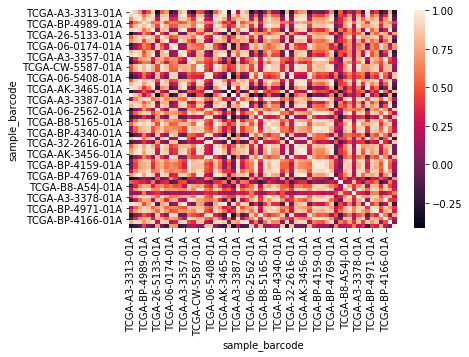

In [0]:
# unsorted #
sb.heatmap(cormat, annot=False, )

In [0]:
# to create the color bar, indicating the sample sources,
# we're going to create a data frame indexed by sample barcode
# and mark KIRC as red and GBM as blue
lut = {'TCGA-KIRC' : 'r', 'TCGA-GBM': 'b'}
row_colors = tissueType['project_short_name'].map(lut)

To get a clustered heatmap, like we're more used to seeing, we use the seaborn 'clustermap'.  Parameters allow for clustering rows and columns.

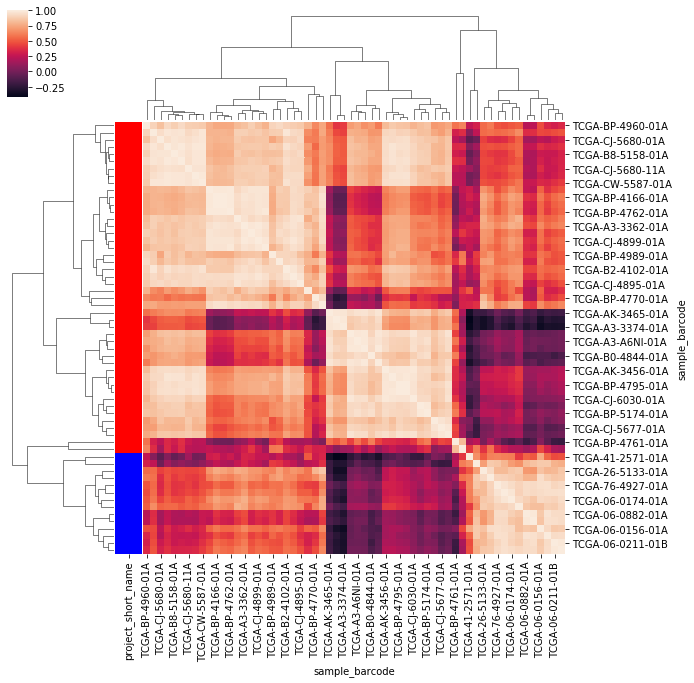

In [0]:
plt = sb.clustermap(cormat, row_colors=row_colors)

Cool! The tissue types separated out, and it looks like KIRC (red bar) clusters into two groups. 


# Wrapping up and writing results and figures  back to our bucket.

In [0]:
# saving the clustered heatmap #
plt.savefig('tcga_clustered_heatmap.png')

In [0]:
!gsutil cp tcga_clustered_heatmap.png gs://my-project/heatmaps

In [0]:
# That's it!